<h2 style="color: #c0392b;">📊 Metadata about the Data we Have:</h2> 

we have data after incoding


In [1]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load processed data
df = pd.read_csv(r"C:\Users\bhbt\Desktop\Sales-Forcasting-Project\1. data/processed\Sales__cleaned.csv")




C:\Users\bhbt\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### *Prophet Model*

In [2]:
df['Order Date'] = pd.to_datetime(df['Order Year'].astype(str) + '-' + df['Order Month'].astype(str) + '-01')

In [3]:
monthly_sales = df.groupby('Order Date')['Sales_log'].sum().reset_index()

In [4]:
sales_series = monthly_sales.set_index('Order Date')
sales_series = sales_series.rename(columns={'Sales_log': 'Sales'})

In [36]:
prophet_df = monthly_sales[['Order Date', 'Sales_log']].rename(columns={
    'Order Date': 'ds',
    'Sales_log': 'y'
})

In [37]:
# تقسيم البيانات
train_prophet = prophet_df[:-6]
test_prophet = prophet_df[-6:]  # <-- مش test العادية!

In [38]:
# تدريب الموديل
model_prophet = Prophet()
model_prophet.fit(train_prophet)

05:37:05 - cmdstanpy - INFO - Chain [1] start processing
05:37:05 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# توقع الشهور الجاية
future = model_prophet.make_future_dataframe(periods=6, freq='MS')
forecast_prophet = model_prophet.predict(future)

In [40]:
# التقييم
test_dates = test_prophet['ds']
forecast_test = forecast_prophet.set_index('ds').loc[test_dates]

In [41]:
y_true = test_prophet['y'].values
y_pred = forecast_test['yhat'].values

In [42]:
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
mae_prophet = mean_absolute_error(y_true, y_pred)
print("Prophet Forecast Evaluation:")
print(f"RMSE: {rmse_prophet:.2f}")
print(f"MAE: {mae_prophet:.2f}")

Prophet Forecast Evaluation:
RMSE: 206.05
MAE: 168.09


C:\Users\bhbt\AppData\Local\Temp\ipykernel_44408\746180240.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bhbt\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


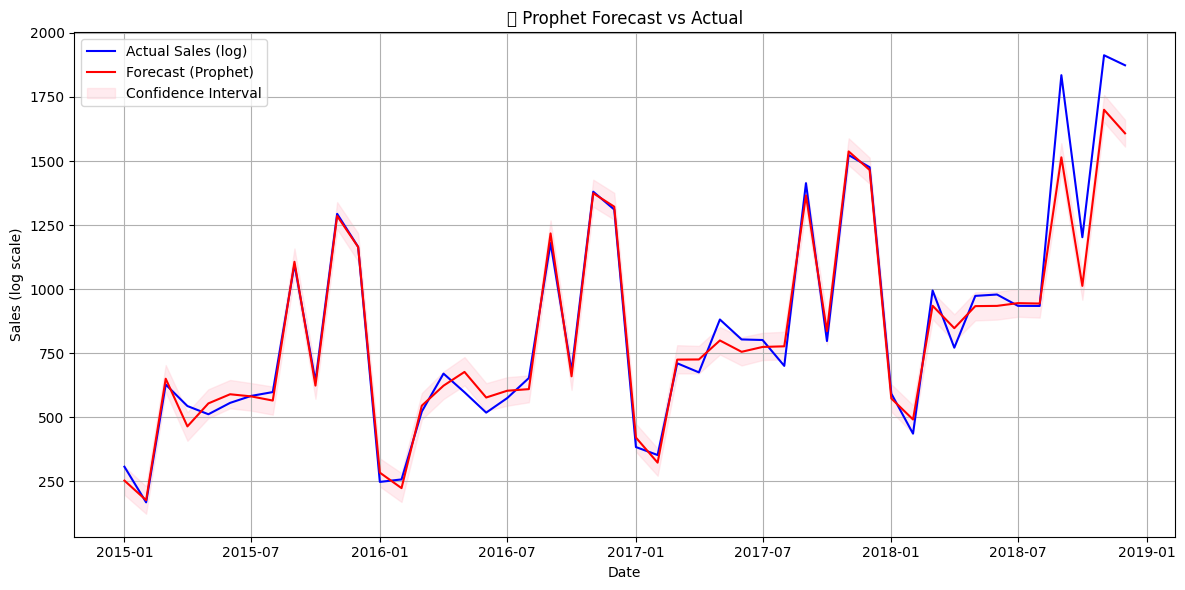

In [43]:
import matplotlib.pyplot as plt

# تأكد إن forecast_prophet و prophet_df متاحين
plt.figure(figsize=(12, 6))

# رسم البيانات الفعلية (التاريخ الحقيقي)
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual Sales (log)', color='blue')

# رسم التنبؤات
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Forecast (Prophet)', color='red')

# رسم حدود الثقة
plt.fill_between(forecast_prophet['ds'], 
                 forecast_prophet['yhat_lower'], 
                 forecast_prophet['yhat_upper'], 
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title("📈 Prophet Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales (log scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### *ARIMA*

In [14]:
train = sales_series[:-6]
test = sales_series[-6:]

In [15]:
# تدريب الموديل (الباراميتر ممكن تعدلهم حسب الأداء)
model = ARIMA(train, order=(1,1,1))  # (p,d,q)
model_fit = model.fit()

C:\Users\bhbt\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bhbt\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bhbt\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
forecast = model_fit.forecast(steps=6)
forecast.index = test.index

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)

print("ARIMA (statsmodels)")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")


ARIMA (statsmodels)
RMSE: 713.583
MAE: 561.025


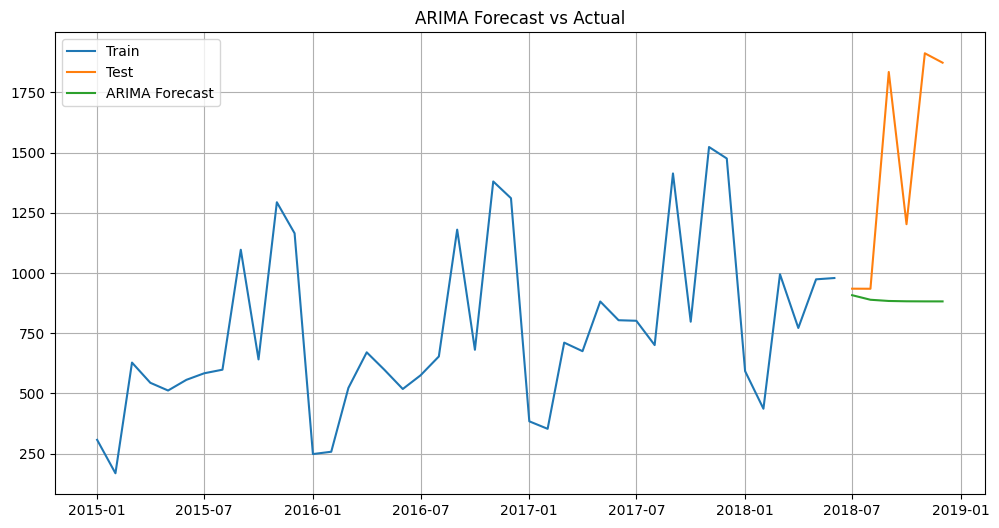

In [21]:
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='ARIMA Forecast')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()

### *Prophet  ARIMA in both RMSE and MAE.*

📊 Model Comparison:
ARIMA   → RMSE: 713.58, MAE: 561.03
Prophet → RMSE: 206.05, MAE: 168.09


C:\Users\bhbt\AppData\Local\Temp\ipykernel_44408\2920905209.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])
C:\Users\bhbt\AppData\Local\Temp\ipykernel_44408\2920905209.py:46: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bhbt\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


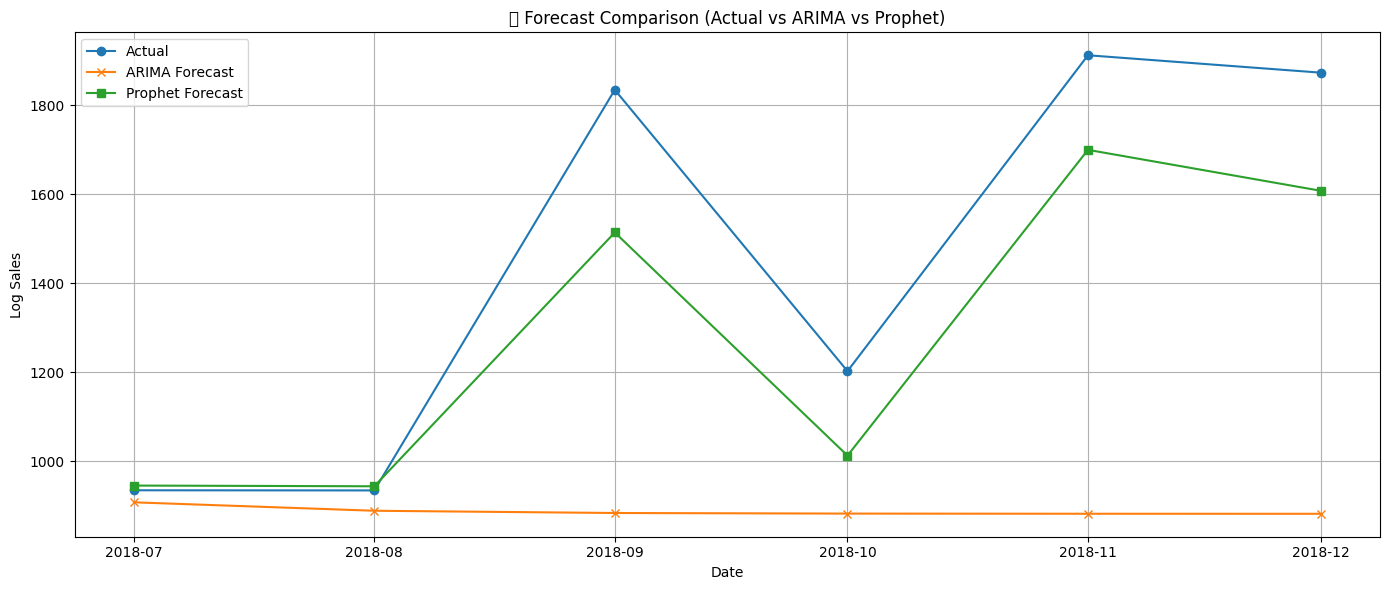

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# تأكد إن الأعمدة المطلوبة موجودة
assert 'ds' in test_prophet.columns and 'y' in test_prophet.columns, "test_prophet must contain 'ds' and 'y' columns"
assert 'ds' in forecast_prophet.columns and 'yhat' in forecast_prophet.columns, "forecast_prophet must contain 'ds' and 'yhat'"

# نحول ds إلى datetime إذا مش datetime
forecast_prophet['ds'] = pd.to_datetime(forecast_prophet['ds'])
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

# نحدد تواريخ التست
test_dates = test_prophet['ds'].values

# نجيب التوقعات من Prophet لنفس التواريخ
forecast_test_prophet = forecast_prophet.set_index('ds').loc[test_dates]

# القيم الفعلية والمتوقعة
y_true = test_prophet['y'].values
y_pred_arima = forecast[:len(test_prophet)]  # توقعات ARIMA
y_pred_prophet = forecast_test_prophet['yhat'].values

# حساب RMSE و MAE
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
mae_arima = mean_absolute_error(y_true, y_pred_arima)

rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred_prophet))
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)

# طباعة النتائج
print("📊 Model Comparison:")
print(f"ARIMA   → RMSE: {rmse_arima:.2f}, MAE: {mae_arima:.2f}")
print(f"Prophet → RMSE: {rmse_prophet:.2f}, MAE: {mae_prophet:.2f}")

# رسم النتائج
plt.figure(figsize=(14, 6))
plt.plot(test_prophet['ds'], y_true, label='Actual', marker='o')
plt.plot(test_prophet['ds'], y_pred_arima, label='ARIMA Forecast', marker='x')
plt.plot(test_prophet['ds'], y_pred_prophet, label='Prophet Forecast', marker='s')
plt.title('📈 Forecast Comparison (Actual vs ARIMA vs Prophet)')
plt.xlabel('Date')
plt.ylabel('Log Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📝 Forecasting Model Evaluation Report

Two time series models were trained and compared to forecast monthly log-transformed sales:

1. ARIMA Model:
   - RMSE: 713.58
   - MAE: 561.02

2. Prophet Model:
   - RMSE: 206.05
   - MAE: 168.09

🔍 Summary:
The Prophet model significantly outperformed the ARIMA model in both RMSE and MAE, indicating it captured seasonality and trends more effectively.

📈 Visualization confirms Prophet was closer to actual values, especially in recent months.

👉 Recommendation:
Use the Prophet model for deployment and future forecasting tasks.
Prophet Model:

In [50]:
 df.columns.tolist()


['Shipping Time (days)',
 'Order Month',
 'Order Day Of Week',
 'Order Year',
 'Ship Mode_Same Day',
 'Ship Mode_Second Class',
 'Ship Mode_Standard Class',
 'Segment_Corporate',
 'Segment_Home Office',
 'City_Arlington',
 'City_Aurora',
 'City_Charlotte',
 'City_Chicago',
 'City_Columbia',
 'City_Columbus',
 'City_Dallas',
 'City_Detroit',
 'City_Henderson',
 'City_Houston',
 'City_Jackson',
 'City_Jacksonville',
 'City_Long Beach',
 'City_Los Angeles',
 'City_Louisville',
 'City_Miami',
 'City_New York City',
 'City_Newark',
 'City_Philadelphia',
 'City_Phoenix',
 'City_Richmond',
 'City_Rochester',
 'City_San Antonio',
 'City_San Diego',
 'City_San Francisco',
 'City_Seattle',
 'City_Springfield',
 'State_Arizona',
 'State_Arkansas',
 'State_California',
 'State_Colorado',
 'State_Connecticut',
 'State_Delaware',
 'State_Florida',
 'State_Georgia',
 'State_Illinois',
 'State_Indiana',
 'State_Kentucky',
 'State_Maryland',
 'State_Massachusetts',
 'State_Michigan',
 'State_Minnesota'